# Expedia Hotel Recommendations

<br>
### Objective:

Generate personalized booking recommendations. For example, is the user booking a dream vacation, weekend getaway, business trip or other travel type? In the absence of sufficient uesr data, use historical customer data to identify the type of destination the customer is seeking and present them with the appropriate recommendations.

### Contents:

1. [Exploratory analysis](#exp)
1. [Machine learning approach using random forest](#rf1)
1. [Refined random forest model](#rf2)
1. [Make recommendations directly, based on several search parameters](#nonml)


<a id="exp"></a>

# Exploratory Analysis

___

## Import useful libraries

In [1]:
import pandas as pd
import numpy as np
from scipy import sparse
import random
import re
import multiprocessing
from collections import defaultdict, OrderedDict

from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import log_loss, average_precision_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

import ml_metrics
import joblib

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

___
## Load random subset of data

Due to the large dataset and hardware limitations, a random subset (0.5%) of data is loaded to identify trends among features.

In [8]:
# Read large file in chunks
# Generate random row numbers for 1/200 of each chunk
# create dataframe then append additional

reader = pd.read_csv(dataurl+'train.csv.gz', sep=',', compression='gzip', chunksize=100000)
first = True
for chunk in reader:
    randsamp = random.sample(range(len(chunk)),len(chunk)//200)
    if first:
        df = chunk.iloc[randsamp]
        first = False
    else:
        df = df.append(chunk.iloc[randsamp], ignore_index=True)

In [10]:
# save data to csv for reloading

df.to_csv(dataurl+'train200th.csv', sep=',', encoding='utf-8', index=False)

___
## Relationships among features

Look for correlations among input variables (not including date columns).

In [213]:
cols = list(df.columns)
print(len(cols))
print(cols)

24
['date_time', 'site_name', 'posa_continent', 'user_location_country', 'user_location_region', 'user_location_city', 'orig_destination_distance', 'user_id', 'is_mobile', 'is_package', 'channel', 'srch_ci', 'srch_co', 'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt', 'srch_destination_id', 'srch_destination_type_id', 'is_booking', 'cnt', 'hotel_continent', 'hotel_country', 'hotel_market', 'hotel_cluster']


In [214]:
def dropcol(subcols, drops):
    for drop in drops:
        if drop in subcols:
            subcols.remove(drop)
    return subcols

subcols = dropcol(cols, ['date_time', 'srch_ci', 'srch_co'])
print(len(subcols))
print(subcols)

21
['site_name', 'posa_continent', 'user_location_country', 'user_location_region', 'user_location_city', 'orig_destination_distance', 'user_id', 'is_mobile', 'is_package', 'channel', 'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt', 'srch_destination_id', 'srch_destination_type_id', 'is_booking', 'cnt', 'hotel_continent', 'hotel_country', 'hotel_market', 'hotel_cluster']


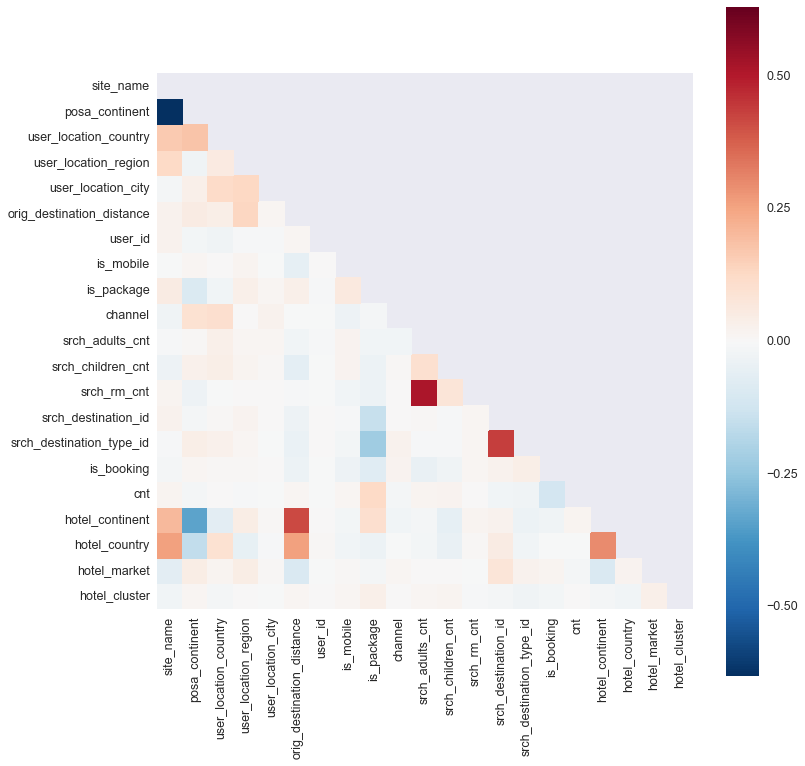

In [177]:
corr = df[subcols].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.set(font_scale=1.25)
f,ax = plt.subplots(1,1,figsize=(12,12))
_ = sns.heatmap(corr, mask=mask, vmax=0.5, square=True, ax=ax)

A strong correlation is apparent between a few variables suggesting that one member of the pair can be excluded from the model.

In [116]:
# Pairs correlated stronger than +/- 0.4

pairs = defaultdict(list)
for col in corr.columns:
    curr = list(corr[col][(abs(corr[col])>=0.4) & (corr[col]!=1)].index)
    if len(curr)>0 and not any([col in v for v in pairs.values()]):
        pairs[col]=curr
pairs

defaultdict(list,
            {'orig_destination_distance': ['hotel_continent'],
             'site_name': ['posa_continent'],
             'srch_adults_cnt': ['srch_rm_cnt'],
             'srch_destination_id': ['srch_destination_type_id']})

___
## Feature selection

To select which variable to exclude from the correlated pair, consider two quantities:
1. Correlation with output
1. Features variance. 

*Greater variance and stronger correlation with output will improve discriminating power.*

However, for the correlation between `orig_destination_distance` and `hotel_continent`, the distance metric will be kept since the correlation most likely shows that customers from certain continents book hotels on other continents and discarding the distance feature will lose a lot of information for customers that do not travel to foreign countries or continents.

In [143]:
# Check correlation of each feature with output

sercorrout = corr['hotel_cluster'].abs()
sercorrout.drop('hotel_cluster', inplace=True)
sercorrout.sort_values(inplace=True)
sercorrout

user_location_region         0.002227
channel                      0.002301
user_id                      0.002303
cnt                          0.003040
user_location_city           0.003254
srch_rm_cnt                  0.005417
orig_destination_distance    0.009926
srch_adults_cnt              0.010323
srch_destination_id          0.010529
user_location_country        0.011087
is_mobile                    0.012176
hotel_continent              0.012815
posa_continent               0.013590
srch_children_cnt            0.017408
is_booking                   0.019307
site_name                    0.022608
hotel_country                0.023831
srch_destination_type_id     0.028516
hotel_market                 0.034823
is_package                   0.036482
Name: hotel_cluster, dtype: float64

In [163]:
# Min-max standardize values and compare standard deviation

cols = ['srch_adults_cnt','srch_rm_cnt']

def featureselect(cols):
    mmscaled = preprocessing.minmax_scale(df[cols])
    dfmm = pd.DataFrame(mmscaled, columns=cols)
    dvars = dfmm.var().to_dict()
    dcorrs = dict(zip(cols,[sercorrout.loc[k] for k in cols]))
    # compare relative differences
    dscores = {}
    for col in cols:
        val = dvars[col]/sum(dvars.values()) + dcorrs[col]/sum(dcorrs.values())
        dscores[val] = col
    print('Variance:', dvars)
    print('Correlation with output:', dcorrs)
    print('Score:', dscores)
    print('')
    print('Feature to keep from correlated pair:', dscores[max(dscores)])
    print('Feature to drop:', dscores[min(dscores)])
    return

featureselect(cols)

Variance: {'srch_rm_cnt': 0.0033440957707676832, 'srch_adults_cnt': 0.010348964884441899}
Correlation with output: {'srch_rm_cnt': 0.0054174647407086093, 'srch_adults_cnt': 0.010323018936554905}
Score: {0.58839225259332428: 'srch_rm_cnt', 1.4116077474066757: 'srch_adults_cnt'}

Feature to keep from correlated pair: srch_adults_cnt
Feature to drop: srch_rm_cnt


In [164]:
p1 = 'srch_destination_id'

featureselect([p1, pairs[p1][0]])

Variance: {'srch_destination_type_id': 0.072431445265535896, 'srch_destination_id': 0.028589649539407042}
Correlation with output: {'srch_destination_type_id': 0.028516253917846818, 'srch_destination_id': 0.010529017100625929}
Score: {0.55266850371112275: 'srch_destination_id', 1.4473314962888773: 'srch_destination_type_id'}

Feature to keep from correlated pair: srch_destination_type_id
Feature to drop: srch_destination_id


In [192]:
p1 = 'site_name'

featureselect([p1, pairs[p1][0]])

Variance: {'posa_continent': 0.035079832030670187, 'site_name': 0.055031869189630621}
Correlation with output: {'posa_continent': 0.013589939138183623, 'site_name': 0.022607651686052908}
Score: {0.76473042004943226: 'posa_continent', 1.2352695799505677: 'site_name'}

Feature to keep from correlated pair: site_name
Feature to drop: posa_continent


In [215]:
# Remove columns

subcols = dropcol(subcols, ['srch_rm_cnt','srch_destination_id','posa_continent'])
print(len(subcols))
print(subcols)

18
['site_name', 'user_location_country', 'user_location_region', 'user_location_city', 'orig_destination_distance', 'user_id', 'is_mobile', 'is_package', 'channel', 'srch_adults_cnt', 'srch_children_cnt', 'srch_destination_type_id', 'is_booking', 'cnt', 'hotel_continent', 'hotel_country', 'hotel_market', 'hotel_cluster']


Using this strategy for feature selection returns the above list of features to retain.

___
## Additional feature selection

### Does binary data surpass the variance threshold?

Binary column names begin with `is`.

In [182]:
p = re.compile('^(is)')
bicols = [c for c in df.columns if p.search(c)]
bicols

['is_mobile', 'is_package', 'is_booking']

In [196]:
# Probability of occurence threshold
p = 0.9

sel = VarianceThreshold(p*(1-p))
sel.fit_transform(df[bicols])
bipass = [bicols[i] for i in range(len(bicols)) if sel.get_support()[i]==True]
print('Features that pass threshold:', bipass)
bidrop = [c for c in bicols if c not in bipass]
print('Features to drop:', bidrop)

Features that pass threshold: ['is_mobile', 'is_package']
Features to drop: ['is_booking']


In [216]:
# Remove columns

subcols = dropcol(subcols, bidrop)
print(len(subcols))
print(subcols)

17
['site_name', 'user_location_country', 'user_location_region', 'user_location_city', 'orig_destination_distance', 'user_id', 'is_mobile', 'is_package', 'channel', 'srch_adults_cnt', 'srch_children_cnt', 'srch_destination_type_id', 'cnt', 'hotel_continent', 'hotel_country', 'hotel_market', 'hotel_cluster']


**Remove and set aside output variable for model construction.**

In [217]:
subcols = dropcol(subcols, ['hotel_cluster'])
print(len(subcols))
print(subcols)

16
['site_name', 'user_location_country', 'user_location_region', 'user_location_city', 'orig_destination_distance', 'user_id', 'is_mobile', 'is_package', 'channel', 'srch_adults_cnt', 'srch_children_cnt', 'srch_destination_type_id', 'cnt', 'hotel_continent', 'hotel_country', 'hotel_market']


### Finally, is user_id important?

In [9]:
len(dfXy['user_id'].unique())/len(dfXy)

0.8144952774341522

`user_id` is mostly unique values so unlikely to have a significant effect on outcome.

<a id="rf1"></a>

<br>

# Test random forest model

___
## First identify and remove missing values

In [207]:
dnas = {}
for col in subcols:
    nullcount = df[col].isnull().sum()
    if nullcount > 0:
        dnas[col] = nullcount
print(dnas)

{'orig_destination_distance': 67584}


In [219]:
# Drop this column from the training data
# Since it is highly correlated with hotel continent, little information will be lost

subcols = dropcol(subcols, dnas.keys())
print(len(subcols))
print(subcols)

15
['site_name', 'user_location_country', 'user_location_region', 'user_location_city', 'user_id', 'is_mobile', 'is_package', 'channel', 'srch_adults_cnt', 'srch_children_cnt', 'srch_destination_type_id', 'cnt', 'hotel_continent', 'hotel_country', 'hotel_market']


___
## Create save point

In [11]:
outcols = ['site_name', 'user_location_country', 'user_location_region', 'user_location_city', 
           'is_mobile', 'is_package', 'channel', 'srch_adults_cnt', 'srch_children_cnt', 
           'srch_destination_type_id', 'hotel_continent', 'hotel_country', 'hotel_market', 'hotel_cluster']
dfXy = dfXy[outcols].copy()

dfXy.to_csv(dataurl+'train200thdrop.csv', sep=',', encoding='utf-8', index=False)

___
## Reload data if necessary

In [137]:
dataurl = '/Users/dbricare/Documents/Python/datasets/expedia/'
dfXy = pd.read_csv(dataurl+'train200th.csv', sep=',', encoding='utf-8')

# drop 'cnt' because it is not present in test dataset
# dfXy.drop('cnt', axis=1, inplace=True)
# dfXy.to_csv(dataurl+'train200thdrop.csv', sep=',', encoding='utf-8', index=False)
print(dfXy.shape)
print(list(dfXy.columns))

(188351, 24)
['date_time', 'site_name', 'posa_continent', 'user_location_country', 'user_location_region', 'user_location_city', 'orig_destination_distance', 'user_id', 'is_mobile', 'is_package', 'channel', 'srch_ci', 'srch_co', 'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt', 'srch_destination_id', 'srch_destination_type_id', 'is_booking', 'cnt', 'hotel_continent', 'hotel_country', 'hotel_market', 'hotel_cluster']


___
## Parse date time

In [151]:
def parsedatetime(dfXy):
    # create new feature for length of stay
    for col in ['date_time', 'srch_ci', 'srch_co']:
        dfXy[col] = pd.to_datetime(dfXy[col], errors='coerce')
    # convert booking datetime to month
    dfXy['bookdoy'] = dfXy['date_time'].apply(lambda x: x.dayofyear)
    # some checkout values missing, fill with datetime
    dfXy['srch_co'].fillna(dfXy['date_time'], inplace=True)
    dfXy['srch_ci'].fillna(dfXy['date_time'], inplace=True)
    # convert stay to length and dayofyear
    dfXy['stay'] = dfXy['srch_co']-dfXy['srch_ci']
    dfXy['stay'] = dfXy['stay'].apply(lambda x: x.days)
    dfXy['staydoy'] = dfXy['srch_ci'].apply(lambda x: x.dayofyear)
    return dfXy

# drop 225 null checkouts
dfXy.dropna(axis=0, subset=['srch_ci'], inplace=True)

dfXy = parsedatetime(dfXy)

# serdtbook = pd.to_datetime(X['date_time']).apply(lambda x: x.month)
dfXy.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,bookdoy,stay,staydoy
0,2014-02-10 21:49:43,18,2,231,68,42296,NaN,150736,0,1,...,6,0,1,6,105,29,35,41,2,89
1,2014-10-21 17:17:41,13,1,46,171,56407,5763.2976,72327,0,0,...,1,0,1,5,203,253,58,294,7,339
2,2013-08-31 16:52:22,2,3,66,220,14656,188.2171,193997,1,0,...,1,0,1,2,50,682,79,243,3,266
3,2014-11-09 12:14:12,34,3,205,155,14703,60.4896,163092,0,0,...,1,0,1,2,198,401,95,313,1,326
4,2014-06-18 09:22:40,2,3,66,435,40631,4362.4117,120073,0,0,...,1,0,1,6,204,27,72,169,3,192


Split data into train and test sets, create output dummy variables and drop unwanted columns

In [120]:
# dropcols = ['hotel_cluster', 'user_location_country', 'user_location_city', 'user_location_region', 
#             'hotel_country', 'hotel_market']
dropcols = ['hotel_cluster', 'cnt', 'user_id', 'orig_destination_distance', 'srch_rm_cnt', 'srch_destination_id', 
           'posa_continent', 'date_time', 'srch_ci', 'srch_co', 'is_mobile', 'user_location_city', 'channel', 
            'is_booking']
y = dfXy['hotel_cluster'].astype(int)
if len(dropcols)>0:
    X = dfXy.drop(dropcols, axis=1)
else:
    X = dfXy.drop('hotel_cluster', axis=1)
print(X.shape)
print(list(X.columns))

sss = StratifiedShuffleSplit(y, test_size=0.3, random_state=42, n_iter=1)
for train_index, test_index in sss:
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

X.head()

(188126, 13)
['site_name', 'user_location_country', 'user_location_region', 'is_package', 'srch_adults_cnt', 'srch_children_cnt', 'srch_destination_type_id', 'hotel_continent', 'hotel_country', 'hotel_market', 'bookdoy', 'stay', 'staydoy']


,site_name,user_location_country,user_location_region,is_package,srch_adults_cnt,srch_children_cnt,srch_destination_type_id,hotel_continent,hotel_country,hotel_market,bookdoy,stay,staydoy
0,18,231,68,1,4,0,6,6,105,29,41,2,89
1,13,46,171,0,2,0,1,5,203,253,294,7,339
2,2,66,220,0,3,0,1,2,50,682,243,3,266
3,34,205,155,0,2,0,1,2,198,401,313,1,326
4,2,66,435,0,2,0,1,6,204,27,169,3,192


In [121]:
rfparams = {'n_jobs': 3}
gridparams = {'n_estimators': [25,50,75], 'max_depth' : [8,12,16]}

clf = RandomForestClassifier(random_state=42, class_weight='balanced', **rfparams)
# clf = GradientBoostingClassifier(random_state=42, **params)
# clf.fit(X_train, y_train)

grid = GridSearchCV(clf, param_grid=gridparams, cv=3, scoring='log_loss')
grid.fit(X_train, y_train)

print(grid.best_params_)
grid.grid_scores_

{'n_estimators': 75, 'max_depth': 16}


[mean: -3.89073, std: 0.01437, params: {'n_estimators': 25, 'max_depth': 8},
 mean: -3.88040, std: 0.00680, params: {'n_estimators': 50, 'max_depth': 8},
 mean: -3.87464, std: 0.00304, params: {'n_estimators': 75, 'max_depth': 8},
 mean: -3.76308, std: 0.00178, params: {'n_estimators': 25, 'max_depth': 12},
 mean: -3.73708, std: 0.00570, params: {'n_estimators': 50, 'max_depth': 12},
 mean: -3.72322, std: 0.00779, params: {'n_estimators': 75, 'max_depth': 12},
 mean: -3.91921, std: 0.00832, params: {'n_estimators': 25, 'max_depth': 16},
 mean: -3.76277, std: 0.01243, params: {'n_estimators': 50, 'max_depth': 16},
 mean: -3.71235, std: 0.01038, params: {'n_estimators': 75, 'max_depth': 16}]

___
## Save trained model to disk

In [92]:
joblib.dump(clf, 'gbc200th.pkl', compress=True)

['gbc200th.pkl']

___

## Relative feature importance

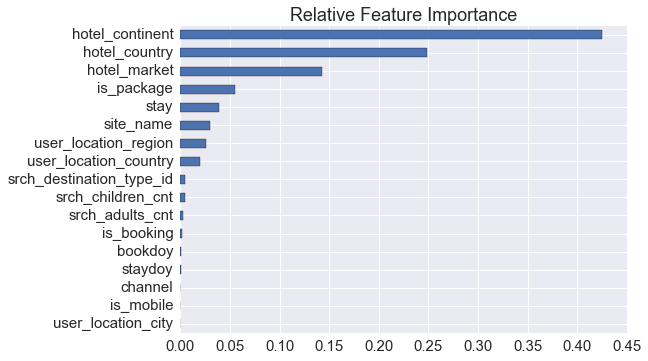

In [60]:
sns.set(font_scale=1.5)
serfeatures = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=True)
_ = serfeatures.plot(kind='barh')
_ = plt.title('Relative Feature Importance')

In [16]:
log_loss(y_test, clf.predict_proba(X_test))

4.3140226413733886

### After looking at this data, it appears the user city location, channel and if the booking was done on mobile don't have strong influence over the result. Suggest dropping them to simplify the model.

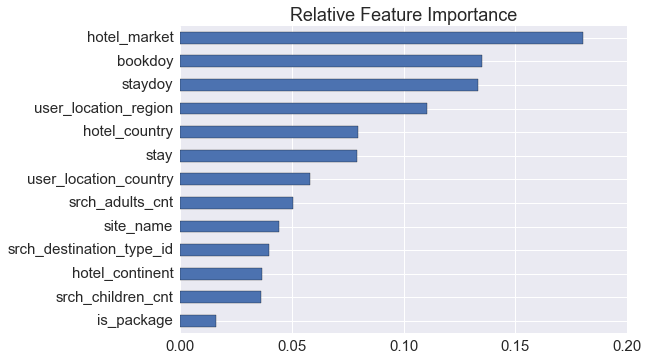

In [122]:
clf.set_params(**grid.best_params_)
clf.fit(X_train, y_train)

sns.set(font_scale=1.5)
serfeatures = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=True)
_ = serfeatures.plot(kind='barh')
_ = plt.title('Relative Feature Importance')

In [123]:
log_loss(y_test, clf.predict_proba(X_test))

3.6633599347203667

In [326]:
# Convert log probabilities to five recommendations

def logtorec(x):
    ypred = list(zip(x, list(range(100))))
    ypred5 = ' '.join([str(t[1]) for t in sorted(ypred, reverse=True)][:5])
    return ypred5

In [327]:
dfpred = pd.DataFrame(pred)
serpred = dfpred.apply(logtorec, axis=1)
serpred.name = 'hotel_cluster'
serpred.to_csv('testoutput.csv', sep=',', index_label='id', header=True)

serpred.head()

0      91 68 9 2 92
1     82 30 5 64 25
2    91 48 41 55 95
3     30 82 5 62 25
4    91 48 41 18 70
Name: hotel_cluster, dtype: object

**The above model uses integer values to represent categories, however the random forest model interprets this data as ordinal which is not correct.**

<a id="rf2"></a>

# Repeat random forest


___
## Convert integer-based category features to bernoulli features
<br>
Using a one-hot encoding will create a series of binary-valued features for each category. To minimize memory usage, store the dataset as a sparse matrix.

Also reduce the number of features to simplify the model further.

In [72]:
# function definitions

def formatdata(chunk):
    '''Format data of each startified chunk.'''
    
    # fill or drop NAs for origin-destination distance
    chunk['orig_destination_distance'].fillna(0.0, inplace=True)
    chunk['orig_destination_distance'].round(4)
    # chunk.dropna(axis=0, subset=['orig_destination_distance'], inplace=True)
      
    return chunk

def stratshufspl(chunk, fraction, ylabel):
    '''Startified shuffle split of chunks.'''
    sss = StratifiedShuffleSplit(chunk[ylabel], test_size=fraction, 
                                 random_state=42, n_iter=1)
    for _, idx in sss:
        train = chunk.iloc[idx].copy()
    return train


def fractionate(trainiter, fraction, ylabel):
    '''Utilizes only one core.'''
    print('')
    print('loading data...')
    
    # create empty list and add formatted data chunks
    chunks = list()
    for chunk in trainiter:
        # chunk = chunk[chunk['is_booking']==1]   # train only on booking events
        # if using whole dataset skip this step
        if fraction < 1.0:
            chunk = stratshufspl(chunk, fraction, ylabel)
        curr = formatdata(chunk)
        chunks.append(curr)
        
    # concatenate chunks
    train = pd.concat(chunks, axis=0)
    
    # split concatenated set into X and y for ml model fitting
    # X = train.drop([ylabel, 'is_booking'], axis=1, inplace=False)
    # y = train[ylabel]
    return train

In [ ]:
dataurl = '/Users/dbricare/Documents/Python/datasets/expedia/'

rawcols = ['user_location_city', 'orig_destination_distance', 'is_booking', 'hotel_cluster']

ylabel = rawcols[-1]

# csviter = pd.read_csv(dataurl+'train.csv.gz', sep=',', compression='gzip', chunksize=2000000, usecols=rawcols)
csviter = pd.read_csv(dataurl+'train.csv.gz', sep=',', chunksize=1000000, usecols=rawcols)

X, y = fractionate(csviter, 0.2, rawcols[-1])

In [320]:
Xtraindum, traincols, trainsparse = sparsify(X_train)
Xtestdum = sparsify(X_test, traincols, trainsparse)
print(Xtraindum.shape, Xtestdum.shape)

Sparsity ratio: 0.9130434782608696
Data type: <class 'pandas.core.frame.DataFrame'>
(126196, 92) (62155, 92)


In [246]:
for x,y in zip(X_train.iloc[0].index,X_train.iloc[0]):
    print(str(x)+'_'+str(y))

site_name_26
is_mobile_0
is_package_0
channel_2
srch_adults_cnt_2
srch_children_cnt_0
srch_destination_type_id_1
cnt_2
hotel_continent_4


In [ ]:
testcols = ['site_name', 'is_mobile', 'is_package', 'channel', 'srch_adults_cnt', 
                'srch_children_cnt', 'srch_destination_type_id', 'hotel_continent']
dftest = pd.read_csv(dataurl+'test.csv.gz', sep=',', compression='gzip')

In [276]:
dftestdum = trainsparsify(pd.get_dummies(dftest[testcols].astype(str)))
print(dftestdum.shape)

Sparsity ratio: 0.9223300970873787
Training data type: <class 'scipy.sparse.csr.csr_matrix'>
(2528243, 103)


In [283]:
a = set(X_train.columns)
b = set(X_test.columns)
print(a.difference(b))

set()


In [268]:
print(len(a.intersection(b)))

1


In [340]:
# check output
submit = pd.read_csv('mloutput20160428_0512.csv')
print(submit.shape)
submit.tail()

(2528243, 2)


,id,hotel_cluster
2528238,2528238,68 42 83 10 47
2528239,2528239,20 22 90 43 53
2528240,2528240,54 39 40 23 77
2528241,2528241,47 5 69 40 77
2528242,2528242,36 26 46 29 86


In [344]:
reader = pd.read_csv(dataurl+'train.csv.gz', sep=',', compression='gzip', chunksize=100000)

In [348]:
[reader]*2

In [349]:
%timeit -n1 -r1 pd.read_csv(dataurl+'test.csv.gz', sep=',', compression='gzip')
%timeit -n1 -r1 pd.read_csv(dataurl+'test.csv', sep=',')

1 loop, best of 1: 9.13 s per loop
1 loop, best of 1: 8.31 s per loop


In [364]:
rf = RandomForestClassifier()
rfparams = {'random_state' : 42, 'n_jobs' : 8,  'class_weight' : 'balanced', 
                'max_depth': 8, 'n_estimators' : 300, 'max_features' : 0.2}
rf.set_params(**rfparams)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=8, max_features=0.2,
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=8,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [443]:
def stshsp(chunk, key, fraction):
    # chunk, key, fraction = vals
    sss = StratifiedShuffleSplit(chunk[key], test_size=fraction, 
                                 random_state=42, n_iter=1)
    for _, idx in sss:
        train = chunk.iloc[idx]
    return train

def fractionate(trainiter, fraction):
    print('')
    print('loading data...')
    key = 'posa_continent'   # global variable
    numcpu = multiprocessing.cpu_count()
    chunks = []
    with multiprocessing.Pool(numcpu) as pool:
        for chunk in trainiter:
            curr = pool.apply_async(stshsp, (chunk, key, fraction))
            chunks.append(curr.get(timeout=10))
    train = pd.concat(chunks, axis=0)
    X = train.drop(key, axis=1, inplace=False)
    y = train[key]
    return X, y

In [444]:
readertest = pd.read_csv(dataurl+'test.csv.gz', sep=',', compression='gzip', chunksize=100000)

In [445]:
xx,yy = fractionate(readertest, 0.1)


loading data...


In [568]:
a = np.eye(3,3, dtype=int)
b = [[1,0],[0,1]]
X = np.array(b)
y = np.array([[1],[0]], dtype=int).ravel()
gbc = GradientBoostingClassifier(warm_start=True)
for _ in range(2):
    gbc.fit(X,y)

In [569]:
X.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False

In [571]:
gbc.get_params()['n_estimators']

100

In [582]:
X = np.eye(2,2, dtype=int).copy(order='C')
y = np.array([[1],[0]], dtype=int).ravel()
gbc = GradientBoostingClassifier(warm_start=True)
for _ in range(20):
    nprev = gbc.get_params()['n_estimators']
    gbc.set_params(n_estimators=nprev+5)
    gbc.fit(X,y)

In [576]:
import math
math.ceil(37670294/1000000)

38

In [574]:
import sys
sys.stdout.write('1')
sys.stdout.write(' ')
sys.stdout.write('2')

1 2

In [518]:
sss

StratifiedShuffleSplit(labels=[35 58 79 ..., 24 31 16], n_iter=1, test_size=0.33, random_state=42)

In [521]:
for a, b in sss:
    print(a)
    print(b)

[177466 137663 144318 ..., 117089 145744 143824]
[100947  33206 160369 ..., 156031  69547 113181]


In [586]:
len(pd.Series(y).unique())

2

In [593]:
reader = pd.read_csv(dataurl+'train.csv.gz', sep=',', compression='gzip', chunksize=1000000)
count = 0
for chunk in reader:
    count += 1
    sys.stdout.write(str(count))
    sys.stdout.write(' ')
    sys.stdout.write(str(len(chunk)))
    sys.stdout.write(' ')

1 1000000 2 1000000 3 1000000 4 1000000 5 1000000 6 1000000 7 1000000 8 1000000 9 1000000 10 1000000 11 1000000 12 1000000 13 1000000 14 1000000 15 1000000 16 1000000 17 1000000 18 1000000 19 1000000 20 1000000 21 1000000 22 1000000 23 1000000 24 1000000 25 1000000 26 1000000 27 1000000 28 1000000 29 1000000 30 1000000 31 1000000 32 1000000 33 1000000 34 1000000 35 1000000 36 1000000 37 1000000 38 670293 

In [152]:
test = pd.read_csv(dataurl+'test.csv.gz', sep=',', compression='gzip')

In [132]:
ci = set(test[test['srch_ci'].isnull()].index)
co = set(test[test['srch_co'].isnull()].index)
print(ci,co)

{955522, 996823, 1613572, 1854882, 1954468, 1160696, 1212520, 2437227, 2172015, 2137689, 127635, 2018163, 1969941, 691993, 253495, 832438, 77497, 655482, 356828, 2327773, 1375038} {955522, 996823, 1613572, 1854882, 1954468, 2437227, 2137689, 127635, 2018163, 691993, 253495, 1160696, 77497, 655482, 356828, 2327773, 1375038}


In [140]:
set(test[test['date_time'].isnull()].index)

set()

In [124]:
X.stay.describe()

count    188126.000000
mean          3.359137
std           3.265124
min        -322.000000
25%           1.000000
50%           3.000000
75%           4.000000
max         244.000000
Name: stay, dtype: float64

In [146]:
test['srch_ci'].fillna(test['date_time'],inplace=True)
test['srch_co'].fillna(test['date_time'],inplace=True)

In [147]:
test['srch_ci'].head()

0    2016-05-19
1    2016-05-12
2    2015-07-26
3    2015-09-14
4    2015-07-22
Name: srch_ci, dtype: object

In [153]:
dftest = parsedatetime(test)

In [154]:
dftest.head()

,id,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,hotel_continent,hotel_country,hotel_market,bookdoy,stay,staydoy
0,0,2015-09-03 17:09:54,2,3,66,174,37449,5539.0567,1,1,...,0,1,12243,6,6,204,27,246,4,140
1,1,2015-09-24 17:38:35,2,3,66,174,37449,5873.2923,1,1,...,0,1,14474,7,6,204,1540,267,3,133
2,2,2015-06-07 15:53:02,2,3,66,142,17440,3975.9776,20,0,...,0,1,11353,1,2,50,699,158,1,207
3,3,2015-09-14 14:49:10,2,3,66,258,34156,1508.5975,28,0,...,0,1,8250,1,2,50,628,257,2,257
4,4,2015-07-17 09:32:04,2,3,66,467,36345,66.7913,50,0,...,0,1,11812,1,2,50,538,198,1,203


In [130]:
f = lambda x: 0 if x<0 else x
f(-1)

0

## Class weights

In [162]:
y.value_counts(normalize=False).apply(lambda x: len(y)/(100*x)).to_csv('classweights.csv', header=None)

In [182]:
classweights = pd.read_csv('classweights.csv', sep=',', header=None)
classweights.set_index(0, inplace=True)
# classweights.reindex(index=classweights[0])
# classweights.to_dict()
# serweights = pd.Series(classweights[1], index=classweights[0])
classweights[1].to_dict()
# serweights

{0: 0.97575726141078845,
 1: 0.80879621668099744,
 2: 0.83797772828507799,
 3: 1.6502280701754386,
 4: 1.0652661381653454,
 5: 0.6037419768934531,
 6: 0.94583207642031175,
 7: 1.4824743892828998,
 8: 1.1072748675691584,
 9: 0.78222869022869024,
 10: 0.90663132530120483,
 11: 1.0899536500579374,
 12: 1.5038049560351718,
 13: 1.1066235294117648,
 14: 1.8681827209533264,
 15: 1.1757875,
 16: 0.77449979415397285,
 17: 1.0780859598853871,
 18: 0.72106554235339215,
 19: 1.3323371104815864,
 20: 1.2659892328398386,
 21: 0.67187857142857144,
 22: 1.3010096818810513,
 23: 1.469734375,
 24: 2.195169194865811,
 25: 0.71071401586701932,
 26: 0.96080694586312565,
 27: 3.6743359375,
 28: 0.73343469785575044,
 29: 0.95253670886075958,
 30: 0.82801936619718308,
 31: 1.5074198717948717,
 32: 1.2737034529451592,
 33: 0.92083210964268236,
 34: 1.2098135048231509,
 35: 2.5735430916552673,
 36: 0.89243833017077789,
 37: 0.76318864097363082,
 38: 1.3553746397694524,
 39: 1.0855510675129834,
 40: 0.870550670

In [185]:
import datetime
now = datetime.datetime.now()
diff = now-datetime.timedelta(hours=7)
diff.strftime('%Y%m%d_%H%M')

'20160510_1139'

<a id="nonml"></a>

# Non-Machine Learning Approach

___
## Load data

In [73]:
dataurl = '/Users/dbricare/Documents/Python/datasets/expedia/'

rawcols = ['srch_destination_id', 'user_location_country', 
           'user_location_region', 'user_location_city', 
           'hotel_market', 'orig_destination_distance', 
           'is_booking','hotel_cluster']

ylabel = rawcols[-1]

csviter = pd.read_csv(dataurl+'train.csv.gz', sep=',', compression='gzip', chunksize=2000000, usecols=rawcols)

Xy = fractionate(csviter, 1, rawcols[-1])

print(Xy.shape)
print(Xy.columns)
Xy.head()


loading data...
(37670293, 8)
Index(['user_location_country', 'user_location_region', 'user_location_city',
       'orig_destination_distance', 'srch_destination_id', 'is_booking',
       'hotel_market', 'hotel_cluster'],
      dtype='object')


,user_location_country,user_location_region,user_location_city,orig_destination_distance,srch_destination_id,is_booking,hotel_market,hotel_cluster
0,66,348,48862,2234.2641,8250,0,628,1
1,66,348,48862,2234.2641,8250,1,628,1
2,66,348,48862,2234.2641,8250,0,628,1
3,66,442,35390,913.1932,14984,0,1457,80
4,66,442,35390,913.6259,14984,0,1457,21


Most common hotel clusters: [91, 48, 42, 59, 28]


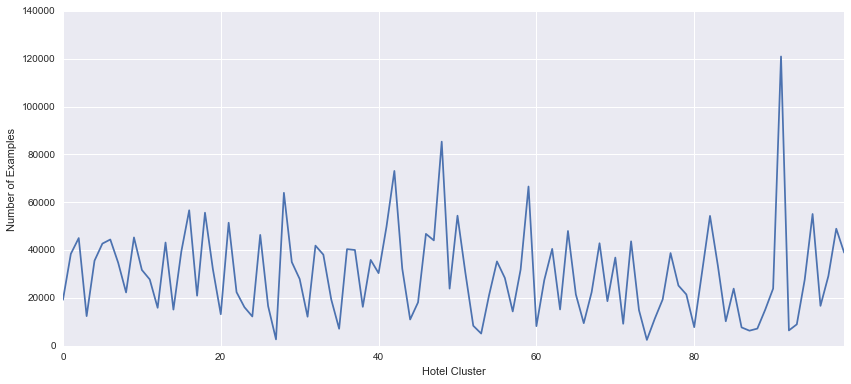

In [69]:
# Distribution of hotel cluster occurrences

f = Xy['hotel_cluster'].value_counts(sort=False).plot(figsize=(14,6))
mostcommon = Xy['hotel_cluster'].value_counts(sort=True).iloc[:5].index.tolist()
print('Most common hotel clusters:', mostcommon)
_ = f.set_ylabel('Number of Examples')
_ = f.set_xlabel('Hotel Cluster')

In [4]:
# divide data into train and test sections

sss = StratifiedShuffleSplit(Xy[Xy.columns[-1]], n_iter=1, test_size=0.2)
for trainidx, testidx in sss:
    # Xtrain, ytrain = Xy[Xy.columns[:-1]].iloc[trainidx], Xy[Xy.columns[-1]].iloc[trainidx]
    Xytrain = Xy.iloc[trainidx]
    Xtest, ytest = Xy[Xy.columns[:-1]].iloc[testidx], Xy[Xy.columns[-1]].iloc[testidx]

## Predict 5 top occurring hotel clusters based on `srch_destination_id`

In [101]:
# # create dictionary of destination IDs and counter including number of occurrences
# # for each hotel cluster

# match_cols = ["srch_destination_id"]
# cluster_cols = match_cols + ['hotel_cluster']

# # group on destination ID then hotel cluster
# groups = Xy.groupby(cluster_cols)

# top_clusters = {}
# for idx, data in groups:
#     clicks = len(data.is_booking[data.is_booking == False])
#     bookings = len(data.is_booking[data.is_booking == True])
#     score = bookings + .15 * clicks
#     cluster_name = str(idx[0])  # idx is (destination ID, hotel cluster)
#     if cluster_name not in top_clusters:
#         top_clusters[cluster_name] = {}
#     top_clusters[cluster_name][idx[-1]] = score

In [74]:
srchidcols = [rawcols[0],rawcols[-2],rawcols[-1]]

Xgroup = Xy[srchidcols].groupby([srchidcols[0],srchidcols[-1]]).count().sort_values('is_booking', ascending=False)
Xgroup.columns = ['count']
Xgroup.head(10)

,,count
srch_destination_id,hotel_cluster,
8250,1,309484
8791,65,177405
8250,45,177232
8267,56,167721
8250,79,167188
8267,70,125801
11439,65,124353
8250,24,122226
12206,1,121597


In [76]:
srchidcols = [rawcols[0],rawcols[-2],rawcols[-1]]
Xbookclick = Xy.copy()
Xbookclick['is_booking'] = Xbookclick['is_booking']+0.2

Xgroup = Xbookclick[srchidcols].groupby([srchidcols[0],srchidcols[-1]]).sum().sort_values('is_booking', 
                                                                                          ascending=False)
Xgroup.columns = ['sum']
Xgroup.head(10)

count
srch_destination_id hotel_cluster              
8250                1              88415.799999
                    45             49206.400000
                    79             46233.600000
8267                56             44988.200000
8791                65             41152.000000
12206               1              34038.400000
8250                24             33847.200000
8267                70             32021.200000
8250                54             29584.600000
11439               65             29015.600000

In [77]:
Xgroup.columns = ['sum']
Xgroup.round(decimals=1)
Xgroup.head()

sum
srch_destination_id hotel_cluster              
8250                1              88415.799999
                    45             49206.400000
                    79             46233.600000
8267                56             44988.200000
8791                65             41152.000000

In [103]:
# # extract top 5 hotel clusters for each destination ID

# cluster_dict = {}
# for n in top_clusters:
#     val = top_clusters[n]
#     top = [l[0] for l in sorted(val.items(), key=operator.itemgetter(1), reverse=True)[:5]]
#     cluster_dict[n] = top

In [116]:
Xtest.head()

,user_location_city,orig_destination_distance,srch_destination_id,is_booking
315100,39058,569.8766,28622,1
788962,11984,3.9448,14797,1
483909,4868,2713.0000,22930,1
743928,2428,4482.8951,21790,1
283337,33958,319.2291,66,1


In [145]:
# example calculation
# create list of top 5 predictions for each row in test set and save to csv

nowpt = datetime.datetime.now()
nowstr = nowpt.strftime('%Y%m%d_%H%M')

preds = Xtest['srch_destination_id'].apply(lambda x: ' '.join([str(i) for i in cluster_dict.get(str(x), [])]))
preds.reset_index(drop=True, inplace=True, name='hotel_cluster')
preds.head()

0    17 51 72 42 43
1    33 32 91 48 13
2    36 62 82 46 29
3     59 21 82 9 99
4    77 48 28 91 47
Name: hotel_cluster, dtype: object

In [125]:
ml_metrics.mapk([[l] for l in ytest], preds, k=5)

0.28583392131169572

## Find exact matches for several features

In [ ]:
# match_cols = ['user_location_country', 'user_location_region', 'user_location_city', 
#               'hotel_market', 'orig_destination_distance']

# groups = Xy.groupby(match_cols)
    
# def generate_exact_matches(row, match_cols):
#     index = tuple([row[t] for t in match_cols])   # grab value in cell
#     try:
#         group = groups.get_group(index)
#     except Exception:
#         return []
#     clusters = list(set(group.hotel_cluster))   # unique hotel clusters
#     print(group)
#     return clusters

# exact_matches = []
# for i in range(2):
#     exact_matches.append(generate_exact_matches(Xtest.iloc[i], match_cols))

In [78]:
# group by desired features

matchcols = ['user_location_country', 'user_location_region', 'user_location_city', 
              'hotel_market', 'orig_destination_distance']

groups = Xy[matchcols+['hotel_cluster']].groupby(matchcols)
# groups.count().head()

In [79]:
# generate dictionary with features as keys and list of clusters as values

exacts = groups.aplpy(lambda x: x['hotel_cluster'].unique().tolist())
print(exacts.shape)
dictexacts = exacts.to_dict()
print(list(dictexacts.items())[:2])

(10622932,)
[((66, 174, 16292, 1630, 113.0115), [93]), ((66, 226, 29254, 548, 388.3634), [40])]


## Combine two prediction methods

In [45]:
# load and format test data

rawcols = ['srch_destination_id', 'user_location_country', 
           'user_location_region', 'user_location_city', 
           'hotel_market', 'orig_destination_distance', 
           'is_booking','hotel_cluster']

testiter = pd.read_csv(dataurl+'test.csv.gz', sep=',', compression='gzip', usecols=rawcols[:-2], 
                       chunksize=1000000)
chunks = list()
for chunk in testiter:
    chunk = formatdata(chunk)
    chunks.append(chunk)

dftest = pd.concat(chunks, axis=0)

print(dftest.shape)
dftest.head()

(2528243, 6)


,user_location_country,user_location_region,user_location_city,orig_destination_distance,srch_destination_id,hotel_market
0,66,174,37449,5539.0567,12243,27
1,66,174,37449,5873.2923,14474,1540
2,66,142,17440,3975.9776,11353,699
3,66,258,34156,1508.5975,8250,628
4,66,467,36345,66.7913,11812,538


In [82]:
# look up test row based on matchcols
# fill in missing values with prediction from srch_destination_id
# trim list to 5 entries
# needs two dictionaries, srch_destination_id needs grouped data

def srchlist(x):
    if x not in Xgroup.index:
        return ''
    else:
        toplist = Xgroup.loc[x].index.tolist()[:5]
        # joinlist = ' '.join([str(i) for i in toplist])
        return toplist
    
dictid = {}
for srchid in dftest['srch_destination_id'].unique():
    dictid[srchid] = srchlist(srchid)

In [85]:
def makepred(x):
    output = dictexacts.get(tuple(x[match_cols]), [])
    if len(output)<5:
        output.extend(dictid[x['srch_destination_id']])
    if len(output)<5:
        output.extend(mostcommon)
    return ' '.join([str(i) for i in output[:5]])

serpred = dftest.apply(makepred, axis=1)

print(serpred.shape)
serpred.head()

(2528243,)


0     5 37 55 11 8
1    5 91 48 42 59
2    91 0 31 77 91
3     1 1 45 79 24
4    50 51 91 2 42
dtype: object

In [62]:
# missing values

len(serpred)-len(serpred[serpred.str.match('\d+')])

20027

In [86]:
nowpt = datetime.datetime.now()
nowstr = nowpt.strftime('%Y%m%d_%H%M')
serpred.reset_index(drop=True, inplace=True, name='hotel_cluster')
serpred.to_csv('mloutput'+nowstr+'.csv', sep=',', index_label='id', header=True)